In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import mlflow
import mlflow.sklearn

# Load the cleaned dataset
data = pd.read_csv('S:/SJSU/DATA_226/group_project/data/processed/cleaned_improved_dataset.csv')

# 1. Feature Engineering
# Include "SKU" in the categorical columns for one-hot encoding
categorical_columns = ["Product type", "SKU", "Customer demographics", "Shipping carriers", 
                       "Supplier name", "Location", "Inspection results", 
                       "Transportation modes", "Routes", "Season"]

# One-hot encoding for all categorical variables, including SKU
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Extract features and target variable
X = data_encoded.drop(columns=["Revenue generated"])  # Features
y = data_encoded["Revenue generated"]  # Target

# Identify the numeric columns for transformations
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns

# Standardize numerical features
scaler = StandardScaler()
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

# Cyclical Encoding for Temporal Features
season_mapping = {"Winter": 0, "Spring": 1, "Summer": 2, "Fall": 3}
data_encoded["Season_Cyclical"] = data["Season"].map(season_mapping)
X["Season_Sin"] = np.sin(2 * np.pi * data_encoded["Season_Cyclical"] / 4)
X["Season_Cos"] = np.cos(2 * np.pi * data_encoded["Season_Cyclical"] / 4)
X = X.drop(columns=["Season_Cyclical"], errors='ignore')

# 2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Start an MLflow run
mlflow.start_run()

# 3. Model Training: Random Forest Regressor
model = RandomForestRegressor(n_estimators=400, random_state=45)
model.fit(X_train, y_train)

# 4. Model Evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Log parameters and metrics to MLflow
mlflow.log_param("n_estimators", 400)
mlflow.log_param("random_state", 45)
mlflow.log_metric("mse", mse)
mlflow.log_metric("r2", r2)

# Log the model
mlflow.sklearn.log_model(model, "random_forest_model")

# End the MLflow run
mlflow.end_run()

# Print metrics
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# 5. Feature Importance Analysis
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Print the top 10 important features
print("\nTop 10 Important Features:")
print(feature_importance_df.head(10))


2024/11/19 16:46:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Mean Squared Error: 0.013185391907327442
R-squared: 0.9926454894831901

Top 10 Important Features:
                    Feature  Importance
2   Number of products sold    0.767571
0                     Price    0.219490
7            Shipping costs    0.001033
1              Availability    0.000952
12                    Costs    0.000902
5          Order quantities    0.000884
13            Demand Factor    0.000839
4                Lead times    0.000729
11             Defect rates    0.000702
8        Production volumes    0.000696


In [3]:
from sklearn.model_selection import RandomizedSearchCV

# Correcting the hyperparameter grid to remove the invalid 'auto' option
param_distributions = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [10, 15, 20, 25, 30, None],
    "min_samples_split": [2, 5, 10, 15],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": ["sqrt", "log2", 0.5, 0.75]  # Removed 'auto' and kept valid options
}

# Initialize the Random Forest model
model = RandomForestRegressor(random_state=45)

# Set up RandomizedSearchCV with the corrected parameter grid
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=20,  # Number of parameter settings to sample
    cv=5,  # 5-fold cross-validation
    verbose=2,  # Print progress
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

# Extract the best model and hyperparameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Log the best parameters and metrics to MLflow
mlflow.start_run()
mlflow.log_params(best_params)
mlflow.log_metric("mse", mse)
mlflow.log_metric("r2", r2)
mlflow.sklearn.log_model(best_model, "random_forest_best_model")
mlflow.end_run()

# Print the best hyperparameters and metrics
best_params, mse, r2


Fitting 5 folds for each of 20 candidates, totalling 100 fits


2024/11/19 16:49:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


({'n_estimators': 100,
  'min_samples_split': 2,
  'min_samples_leaf': 2,
  'max_features': 0.75,
  'max_depth': None},
 np.float64(0.02533564904186372),
 0.9858683535052877)

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import mlflow
import mlflow.sklearn

# Load the cleaned dataset
data = pd.read_csv('S:/SJSU/DATA_226/group_project/data/processed/cleaned_improved_dataset.csv')

# 1. Feature Engineering
# Include "SKU" in the categorical columns for one-hot encoding
categorical_columns = ["Product type", "SKU", "Customer demographics", "Shipping carriers", 
                       "Supplier name", "Location", "Inspection results", 
                       "Transportation modes", "Routes", "Season"]

# One-hot encoding for all categorical variables, including SKU
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Extract features and target variable
X = data_encoded.drop(columns=["Revenue generated"])  # Features
y = data_encoded["Revenue generated"]  # Target

# Identify the numeric columns for transformations
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns

# Standardize numerical features
scaler = StandardScaler()
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

# Cyclical Encoding for Temporal Features
season_mapping = {"Winter": 0, "Spring": 1, "Summer": 2, "Fall": 3}
data_encoded["Season_Cyclical"] = data["Season"].map(season_mapping)
X["Season_Sin"] = np.sin(2 * np.pi * data_encoded["Season_Cyclical"] / 4)
X["Season_Cos"] = np.cos(2 * np.pi * data_encoded["Season_Cyclical"] / 4)
X = X.drop(columns=["Season_Cyclical"], errors='ignore')

# 2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Start an MLflow run
mlflow.start_run()

# 3. Model Training: Random Forest Regressor
model = RandomForestRegressor(n_estimators=400, random_state=45)
model.fit(X_train, y_train)

# 4. Model Evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Log parameters and metrics to MLflow
mlflow.log_param("n_estimators", 400)
mlflow.log_param("random_state", 45)
mlflow.log_metric("mse", mse)
mlflow.log_metric("r2", r2)

# Log feature importances to MLflow
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)
mlflow.log_text(feature_importance_df.to_string(), "feature_importance.txt")

# Log the model
mlflow.sklearn.log_model(model, "random_forest_model")

# End the MLflow run
mlflow.end_run()

# Print metrics
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Print the top 10 important features
print("\nTop 10 Important Features:")
print(feature_importance_df.head(10))

# 5. Warehouse Management Predictions
def predict_inventory_management(new_data):
    """
    Predict warehouse metrics using the trained model.
    """
    # One-hot encode new data and align it with training data
    new_data_encoded = pd.get_dummies(new_data, columns=categorical_columns, drop_first=True)
    
    # Identify missing columns and convert the set to a list
    missing_cols = list(set(X.columns) - set(new_data_encoded.columns))
    
    # Add missing columns with default value 0
    new_data_encoded = pd.concat([new_data_encoded, pd.DataFrame(0, index=new_data_encoded.index, columns=missing_cols)], axis=1)
    
    # Reorder columns to match the training set
    new_data_encoded = new_data_encoded[X.columns]
    
    # Standardize numeric columns
    new_data_encoded[numeric_columns] = scaler.transform(new_data_encoded[numeric_columns])
    
    # Make predictions
    predicted_values = model.predict(new_data_encoded)
    return predicted_values


# Example usage for warehouse management
new_data = pd.DataFrame({
    "Product type": ["haircare"],
    "SKU": ["SKU45"],
    "Price": [25.5],
    "Availability": [100],
    "Number of products sold": [50],
    "Customer demographics": ["Female"],
    "Stock levels": [80],
    "Lead times": [5],
    "Order quantities": [30],
    "Shipping times": [3],
    "Shipping carriers": ["Carrier A"],
    "Shipping costs": [12.5],
    "Supplier name": ["Supplier 1"],
    "Location": ["Mumbai"],
    "Production volumes": [500],
    "Manufacturing lead time": [10],
    "Manufacturing costs": [35.0],
    "Inspection results": ["Pass"],
    "Defect rates": [0.5],
    "Transportation modes": ["Road"],
    "Routes": ["Route A"],
    "Costs": [150.0],
    "Season": ["Winter"],
    "Demand Factor": [1.3]
})

# Generate and print predictions
predicted_values = predict_inventory_management(new_data)
print("Predicted Inventory Metrics:", predicted_values)


2024/11/19 17:03:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Mean Squared Error: 0.013185391907327442
R-squared: 0.9926454894831901

Top 10 Important Features:
                    Feature  Importance
2   Number of products sold    0.767571
0                     Price    0.219490
7            Shipping costs    0.001033
1              Availability    0.000952
12                    Costs    0.000902
5          Order quantities    0.000884
13            Demand Factor    0.000839
4                Lead times    0.000729
11             Defect rates    0.000702
8        Production volumes    0.000696
Predicted Inventory Metrics: [7.24355085]


MultiRegressor Output Model

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import mlflow
import mlflow.sklearn

# Load the cleaned dataset
data = pd.read_csv('S:/SJSU/DATA_226/group_project/data/processed/cleaned_improved_dataset.csv')

# 1. Feature Engineering
# Include "SKU" in the categorical columns for one-hot encoding
categorical_columns = ["Product type", "SKU", "Customer demographics", "Shipping carriers", 
                       "Supplier name", "Location", "Inspection results", 
                       "Transportation modes", "Routes", "Season"]

# One-hot encoding for all categorical variables, including SKU
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Extract features
X = data_encoded.drop(columns=["Revenue generated"])  # Features

# Derive multiple target variables for the warehouse use case
data_encoded["Restock Indicator"] = (data_encoded["Stock levels"] < data_encoded["Demand Factor"] * 10).astype(int)
data_encoded["Restock Date"] = data_encoded["Lead times"]  # Example: Use lead times as a proxy for restock date
data_encoded["Restock Quantity"] = np.maximum(data_encoded["Demand Factor"] * 5, 10)
data_encoded["Predicted Costs"] = data_encoded["Costs"] + data_encoded["Shipping costs"] + data_encoded["Manufacturing costs"]

# Define target variables
y = data_encoded[["Restock Indicator", "Restock Date", "Restock Quantity", "Predicted Costs"]]

# Identify the numeric columns for transformations
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns

# Standardize numerical features
scaler = StandardScaler()
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

# Cyclical Encoding for Temporal Features
season_mapping = {"Winter": 0, "Spring": 1, "Summer": 2, "Fall": 3}
data_encoded["Season_Cyclical"] = data["Season"].map(season_mapping)
X["Season_Sin"] = np.sin(2 * np.pi * data_encoded["Season_Cyclical"] / 4)
X["Season_Cos"] = np.cos(2 * np.pi * data_encoded["Season_Cyclical"] / 4)
X = X.drop(columns=["Season_Cyclical"], errors='ignore')

# 2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Start an MLflow run
mlflow.start_run()

# 3. Multi-Output Model Training: Random Forest Regressor
base_model = RandomForestRegressor(n_estimators=400, random_state=45)
multi_output_model = MultiOutputRegressor(base_model)
multi_output_model.fit(X_train, y_train)

# 4. Model Evaluation
y_pred = multi_output_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
r2 = r2_score(y_test, y_pred, multioutput='variance_weighted')

# Log parameters and metrics to MLflow
mlflow.log_param("n_estimators", 400)
mlflow.log_param("random_state", 45)
mlflow.log_metric("mse_restock_indicator", mse[0])
mlflow.log_metric("mse_restock_date", mse[1])
mlflow.log_metric("mse_restock_quantity", mse[2])
mlflow.log_metric("mse_predicted_costs", mse[3])
mlflow.log_metric("r2_score", r2)

# Log the model
mlflow.sklearn.log_model(multi_output_model, "multi_output_random_forest_model")

# End the MLflow run
mlflow.end_run()

# Print metrics
print(f"Mean Squared Errors: {mse}")
print(f"R-squared: {r2}")

# Extended Prediction Function
def predict_inventory_management(new_data):
    """
    Predict warehouse metrics for multiple SKUs using the trained multi-output model.
    """
    # One-hot encode new data and align it with training data
    new_data_encoded = pd.get_dummies(new_data, columns=categorical_columns, drop_first=True)
    
    # Identify and add any missing columns to match the training data
    missing_cols = list(set(X.columns) - set(new_data_encoded.columns))
    for col in missing_cols:
        new_data_encoded[col] = 0  # Add missing columns with default value 0

    # Reorder columns to match the training set
    new_data_encoded = new_data_encoded[X.columns]

    # Standardize numeric columns
    new_data_encoded[numeric_columns] = scaler.transform(new_data_encoded[numeric_columns])

    # Make predictions
    predictions = multi_output_model.predict(new_data_encoded)

    # Format the results for each SKU
    inventory_metrics = []
    for i in range(len(new_data)):
        metrics = {
            "SKU": new_data["SKU"].iloc[i],
            "Restock Indicator": int(predictions[i][0]),
            "Restock Date (days)": int(predictions[i][1]),
            "Restock Quantity": int(predictions[i][2]),
            "Predicted Costs": round(predictions[i][3], 2)
        }
        inventory_metrics.append(metrics)

    return inventory_metrics

# Example usage for multiple SKUs
new_data = pd.DataFrame({
    "Product type": ["haircare", "skincare"],
    "SKU": ["SKU45", "SKU46"],
    "Price": [25.5, 40.0],
    "Availability": [100, 150],
    "Number of products sold": [50, 60],
    "Customer demographics": ["Female", "Male"],
    "Stock levels": [80, 90],
    "Lead times": [5, 7],
    "Order quantities": [30, 40],
    "Shipping times": [3, 4],
    "Shipping carriers": ["Carrier A", "Carrier B"],
    "Shipping costs": [12.5, 15.0],
    "Supplier name": ["Supplier 1", "Supplier 2"],
    "Location": ["Mumbai", "Delhi"],
    "Production volumes": [500, 700],
    "Manufacturing lead time": [10, 12],
    "Manufacturing costs": [35.0, 50.0],
    "Inspection results": ["Pass", "Fail"],
    "Defect rates": [0.5, 1.0],
    "Transportation modes": ["Road", "Air"],
    "Routes": ["Route A", "Route B"],
    "Costs": [150.0, 200.0],
    "Season": ["Winter", "Summer"],
    "Demand Factor": [1.3, 1.5]
})

# Generate and print predictions for multiple SKUs
predicted_values = predict_inventory_management(new_data)
for item in predicted_values:
    print("Predicted Inventory Metrics:", item)


2024/11/19 17:26:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Mean Squared Errors: [  0.           0.           0.         112.59510873]
R-squared: 0.9918138387587876
Predicted Inventory Metrics: {'SKU': 'SKU45', 'Restock Indicator': 1, 'Restock Date (days)': 7, 'Restock Quantity': 10, 'Predicted Costs': np.float64(203.94)}
Predicted Inventory Metrics: {'SKU': 'SKU46', 'Restock Indicator': 1, 'Restock Date (days)': 7, 'Restock Quantity': 10, 'Predicted Costs': np.float64(254.19)}


C:\Users\saura\AppData\Local\Temp\ipykernel_20016\2830221470.py:95: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_data_encoded[col] = 0  # Add missing columns with default value 0
C:\Users\saura\AppData\Local\Temp\ipykernel_20016\2830221470.py:95: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_data_encoded[col] = 0  # Add missing columns with default value 0
C:\Users\saura\AppData\Local\Temp\ipykernel_20016\2830221470.py:95: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

In [15]:
def predict_inventory_management(new_data):
    """
    Predict warehouse metrics for multiple SKUs using the trained multi-output model.
    """
    # One-hot encode new data and align it with training data
    new_data_encoded = pd.get_dummies(new_data, columns=categorical_columns, drop_first=True)
    
    # Identify and add any missing columns to match the training data
    missing_cols = list(set(X.columns) - set(new_data_encoded.columns))  # Convert to list
    # Create a DataFrame of zeros for missing columns and concatenate
    if missing_cols:
        missing_df = pd.DataFrame(0, index=new_data_encoded.index, columns=missing_cols)
        new_data_encoded = pd.concat([new_data_encoded, missing_df], axis=1)
    
    # Reorder columns to match the training set
    new_data_encoded = new_data_encoded[X.columns]

    # Standardize numeric columns
    new_data_encoded[numeric_columns] = scaler.transform(new_data_encoded[numeric_columns])

    # Make predictions
    predictions = multi_output_model.predict(new_data_encoded)

    # Format the results for each SKU
    inventory_metrics = []
    for i in range(len(new_data)):
        metrics = {
            "SKU": new_data["SKU"].iloc[i],
            "Restock Indicator": int(predictions[i][0]),
            "Restock Date (days)": int(predictions[i][1]),
            "Restock Quantity": int(predictions[i][2]),
            "Predicted Costs": round(predictions[i][3], 2)
        }
        inventory_metrics.append(metrics)

    return inventory_metrics

# Example usage for a new dataset
new_data = pd.DataFrame({
    "Product type": ["haircare", "skincare", "haircare", "skincare"],
    "SKU": ["SKU47", "SKU48", "SKU49", "SKU50"],
    "Price": [30.0, 55.0, 20.0, 75.0],
    "Availability": [120, 80, 90, 110],
    "Number of products sold": [60, 40, 30, 50],
    "Customer demographics": ["Female", "Male", "Non-binary", "Unknown"],
    "Stock levels": [60, 40, 70, 85],
    "Lead times": [4, 6, 8, 10],
    "Order quantities": [25, 35, 20, 30],
    "Shipping times": [2, 5, 3, 4],
    "Shipping carriers": ["Carrier B", "Carrier A", "Carrier C", "Carrier B"],
    "Shipping costs": [14.0, 20.0, 10.0, 18.0],
    "Supplier name": ["Supplier 3", "Supplier 2", "Supplier 1", "Supplier 4"],
    "Location": ["Delhi", "Mumbai", "Kolkata", "Bangalore"],
    "Production volumes": [600, 800, 400, 900],
    "Manufacturing lead time": [12, 15, 8, 10],
    "Manufacturing costs": [40.0, 60.0, 35.0, 50.0],
    "Inspection results": ["Pass", "Fail", "Pending", "Pass"],
    "Defect rates": [1.0, 2.5, 0.5, 1.5],
    "Transportation modes": ["Air", "Road", "Rail", "Air"],
    "Routes": ["Route B", "Route A", "Route C", "Route B"],
    "Costs": [180.0, 250.0, 150.0, 300.0],
    "Season": ["Spring", "Winter", "Fall", "Summer"],
    "Demand Factor": [1.2, 1.5, 0.9, 1.4]
})

# Generate predictions
predicted_values = predict_inventory_management(new_data)

# Print the predictions
for item in predicted_values:
    print("Predicted Inventory Metrics:", item)


Predicted Inventory Metrics: {'SKU': 'SKU47', 'Restock Indicator': 1, 'Restock Date (days)': 7, 'Restock Quantity': 10, 'Predicted Costs': np.float64(242.13)}
Predicted Inventory Metrics: {'SKU': 'SKU48', 'Restock Indicator': 1, 'Restock Date (days)': 7, 'Restock Quantity': 10, 'Predicted Costs': np.float64(309.94)}
Predicted Inventory Metrics: {'SKU': 'SKU49', 'Restock Indicator': 1, 'Restock Date (days)': 8, 'Restock Quantity': 10, 'Predicted Costs': np.float64(204.19)}
Predicted Inventory Metrics: {'SKU': 'SKU50', 'Restock Indicator': 1, 'Restock Date (days)': 10, 'Restock Quantity': 10, 'Predicted Costs': np.float64(354.01)}


In [17]:
!pip install seaborn

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


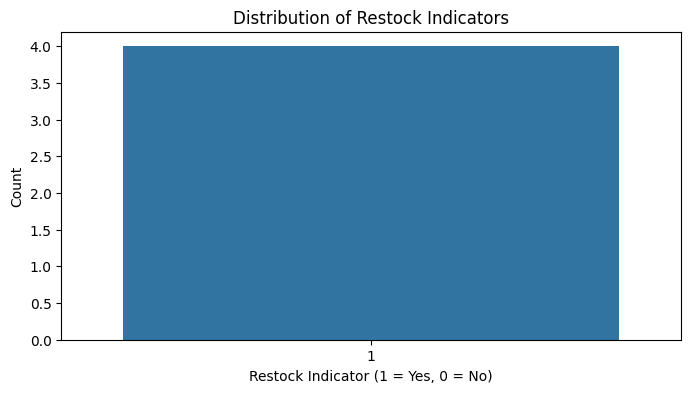

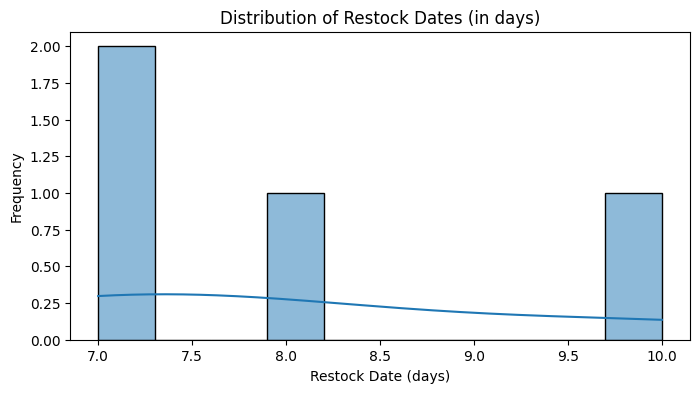

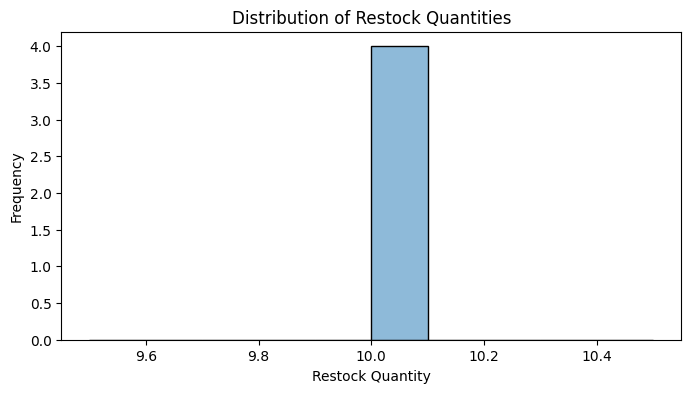

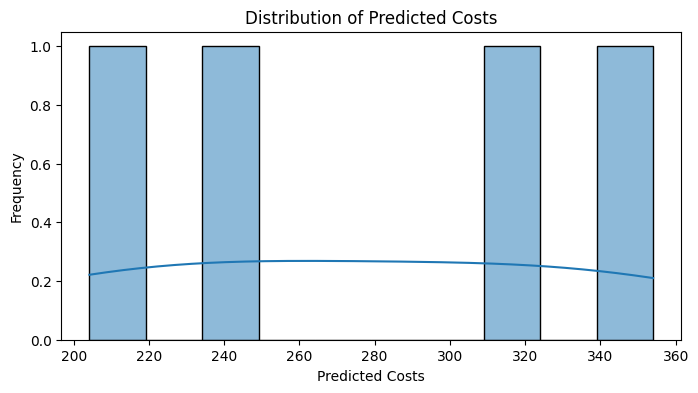

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the predictions into a DataFrame for easier plotting
predicted_df = pd.DataFrame(predicted_values)

# Plotting Restock Indicators
plt.figure(figsize=(8, 4))
sns.countplot(x="Restock Indicator", data=predicted_df)
plt.title("Distribution of Restock Indicators")
plt.xlabel("Restock Indicator (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.show()

# Plotting Restock Dates
plt.figure(figsize=(8, 4))
sns.histplot(predicted_df["Restock Date (days)"], bins=10, kde=True)
plt.title("Distribution of Restock Dates (in days)")
plt.xlabel("Restock Date (days)")
plt.ylabel("Frequency")
plt.show()

# Plotting Restock Quantities
plt.figure(figsize=(8, 4))
sns.histplot(predicted_df["Restock Quantity"], bins=10, kde=True)
plt.title("Distribution of Restock Quantities")
plt.xlabel("Restock Quantity")
plt.ylabel("Frequency")
plt.show()

# Plotting Predicted Costs
plt.figure(figsize=(8, 4))
sns.histplot(predicted_df["Predicted Costs"], bins=10, kde=True)
plt.title("Distribution of Predicted Costs")
plt.xlabel("Predicted Costs")
plt.ylabel("Frequency")
plt.show()


In [1]:
# inventory_simulation.py

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

# 1. Data Simulation Function
def simulate_daily_data(start_date, end_date, skus):
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    simulated_data = []

    for current_date in date_range:
        for sku in skus:
            daily_data = {
                "Date": current_date,
                "Product type": np.random.choice(["haircare", "skincare"]),
                "SKU": sku,
                "Price": np.random.uniform(20.0, 100.0),
                "Availability": np.random.randint(50, 150),
                "Number of products sold": np.random.randint(10, 70),
                "Customer demographics": np.random.choice(["Female", "Male", "Non-binary", "Unknown"]),
                "Stock levels": np.random.randint(20, 100),
                "Lead times": np.random.randint(1, 15),
                "Order quantities": np.random.randint(10, 50),
                "Shipping times": np.random.randint(1, 7),
                "Shipping carriers": np.random.choice(["Carrier A", "Carrier B", "Carrier C"]),
                "Shipping costs": np.random.uniform(10.0, 30.0),
                "Supplier name": np.random.choice(["Supplier 1", "Supplier 2", "Supplier 3", "Supplier 4"]),
                "Location": np.random.choice(["Delhi", "Mumbai", "Kolkata", "Bangalore"]),
                "Production volumes": np.random.randint(400, 1000),
                "Manufacturing lead time": np.random.randint(5, 20),
                "Manufacturing costs": np.random.uniform(30.0, 70.0),
                "Inspection results": np.random.choice(["Pass", "Fail", "Pending"]),
                "Defect rates": np.random.uniform(0.5, 3.0),
                "Transportation modes": np.random.choice(["Air", "Road", "Rail"]),
                "Routes": np.random.choice(["Route A", "Route B", "Route C"]),
                "Costs": np.random.uniform(150.0, 350.0),
                "Season": np.random.choice(["Spring", "Summer", "Fall", "Winter"]),
                "Demand Factor": np.random.uniform(0.8, 1.5)
            }
            simulated_data.append(daily_data)

    return pd.DataFrame(simulated_data)

# 2. Generate Simulated Data for Model Training
def generate_training_data():
    # For simplicity, we'll simulate training data similar to the daily data
    skus = ["SKU" + str(i) for i in range(1, 46)]  # 45 SKUs for training
    start_date = datetime(2022, 1, 1)
    end_date = datetime(2022, 12, 31)  # One year of data

    training_data = simulate_daily_data(start_date, end_date, skus)

    # Add target variables for training
    training_data['Restock Indicator'] = np.random.randint(0, 2, size=len(training_data))
    training_data['Restock Date (days)'] = np.random.randint(5, 15, size=len(training_data))
    training_data['Restock Quantity'] = np.random.randint(10, 100, size=len(training_data))
    training_data['Predicted Costs'] = np.random.uniform(200.0, 500.0, size=len(training_data))

    return training_data

# 3. Prepare Data for Model Training
def prepare_training_data(training_data):
    # Drop unnecessary columns
    X = training_data.drop(columns=['Date', 'SKU', 'Restock Indicator', 'Restock Date (days)', 'Restock Quantity', 'Predicted Costs'])
    y = training_data[['Restock Indicator', 'Restock Date (days)', 'Restock Quantity', 'Predicted Costs']]

    # Identify categorical and numerical columns
    categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
    numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # One-hot encode categorical columns
    X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

    # Standardize numeric columns
    scaler = StandardScaler()
    X_encoded[numeric_columns] = scaler.fit_transform(X_encoded[numeric_columns])

    return X_encoded, y, scaler, categorical_columns, numeric_columns

# 4. Train the Model
def train_model(X, y):
    # Use a Random Forest Regressor as the base estimator
    base_estimator = RandomForestRegressor(n_estimators=100, random_state=42)
    multi_output_model = MultiOutputRegressor(base_estimator)
    multi_output_model.fit(X, y)
    return multi_output_model

# 5. Prediction Function
def predict_inventory_management(new_data, multi_output_model, X_columns, scaler, categorical_columns, numeric_columns):
    """
    Predict warehouse metrics for multiple SKUs using the trained multi-output model.
    """
    # One-hot encode new data and align it with training data
    new_data_encoded = pd.get_dummies(new_data, columns=categorical_columns, drop_first=True)
    
    # Identify and add any missing columns to match the training data
    missing_cols = list(set(X_columns) - set(new_data_encoded.columns))
    # Create a DataFrame of zeros for missing columns and concatenate
    if missing_cols:
        missing_df = pd.DataFrame(0, index=new_data_encoded.index, columns=missing_cols)
        new_data_encoded = pd.concat([new_data_encoded, missing_df], axis=1)
    
    # Reorder columns to match the training set
    new_data_encoded = new_data_encoded[X_columns]

    # Standardize numeric columns
    new_data_encoded[numeric_columns] = scaler.transform(new_data_encoded[numeric_columns])

    # Make predictions
    predictions = multi_output_model.predict(new_data_encoded)

    # Format the results for each SKU
    inventory_metrics = []
    for i in range(len(new_data)):
        metrics = {
            "SKU": new_data["SKU"].iloc[i],
            "Restock Indicator": int(round(predictions[i][0])),
            "Restock Date (days)": int(round(predictions[i][1])),
            "Restock Quantity": int(round(predictions[i][2])),
            "Predicted Costs": round(predictions[i][3], 2)
        }
        inventory_metrics.append(metrics)

    return inventory_metrics

# Generate and prepare training data
training_data = generate_training_data()
X, y, scaler, categorical_columns, numeric_columns = prepare_training_data(training_data)

# Train the model
multi_output_model = train_model(X, y)
X_columns = X.columns  # Save column names for aligning during prediction

# Define the SKUs to simulate
skus = ["SKU47", "SKU48", "SKU49", "SKU50"]

# Define the simulation period
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 1, 31)  # Simulate for one month

# Simulate daily data for the entire period
simulated_data = simulate_daily_data(start_date, end_date, skus)

# Initialize a list to store all daily predictions
daily_predictions = []

# Process data day by day
current_date = start_date
while current_date <= end_date:
    # Get data for the current day
    daily_data = simulated_data[simulated_data['Date'] == current_date]

    if not daily_data.empty:
        # Drop the 'Date' column for prediction
        prediction_data = daily_data.drop(columns=['Date']).reset_index(drop=True)

        # Generate predictions for the day
        predictions = predict_inventory_management(
            prediction_data, multi_output_model, X_columns, scaler, categorical_columns, numeric_columns
        )

        # Add the date to each prediction
        for i, prediction in enumerate(predictions):
            prediction['Date'] = current_date
            prediction['Product type'] = daily_data.iloc[i]['Product type']
            daily_predictions.append(prediction)

    # Move to the next day
    current_date += timedelta(days=1)

# Convert daily_predictions to a DataFrame
predictions_df = pd.DataFrame(daily_predictions)

# Aggregate weekly predictions
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])
predictions_df['Week'] = predictions_df['Date'].dt.isocalendar().week

weekly_predictions = predictions_df.groupby(['Week', 'SKU']).agg({
    'Restock Indicator': 'sum',
    'Restock Date (days)': 'mean',
    'Restock Quantity': 'sum',
    'Predicted Costs': 'sum',
    'Product type': 'first'
}).reset_index()

weekly_predictions = weekly_predictions.sort_values(by=['Week', 'SKU'])

# Save the results to CSV files (optional)
simulated_data.to_csv('simulated_data.csv', index=False)
predictions_df.to_csv('daily_predictions.csv', index=False)
weekly_predictions.to_csv('weekly_predictions.csv', index=False)

# Print the weekly predictions
print("Weekly Predictions:")
print(weekly_predictions)

# Visualize the results
visualize_results(weekly_predictions, skus)

# 7. Visualization Function

# Run the main function
if __name__ == '__main__':
    main()


Weekly Predictions:
    Week    SKU  Restock Indicator  Restock Date (days)  Restock Quantity  \
0      1  SKU47                  3             9.285714               372   
1      1  SKU48                  2             9.857143               364   
2      1  SKU49                  4             9.428571               378   
3      1  SKU50                  2             9.428571               383   
4      2  SKU47                  3             9.428571               380   
5      2  SKU48                  4             9.714286               382   
6      2  SKU49                  4             9.714286               383   
7      2  SKU50                  5             9.285714               389   
8      3  SKU47                  2             9.571429               393   
9      3  SKU48                  2             9.142857               399   
10     3  SKU49                  3             9.428571               370   
11     3  SKU50                  5             9.428571 

NameError: name 'visualize_results' is not defined

In [2]:
prediction_data

,Product type,SKU,Price,Availability,Number of products sold,Customer demographics,Stock levels,Lead times,Order quantities,Shipping times,...,Production volumes,Manufacturing lead time,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs,Season,Demand Factor
0,skincare,SKU47,79.901162,149,54,Male,72,1,14,5,...,892,5,63.785508,Pass,1.562970,Road,Route A,295.296937,Fall,1.030088
1,haircare,SKU48,28.036785,116,51,Non-binary,94,11,13,4,...,737,14,65.725908,Pass,1.971607,Rail,Route C,307.700556,Winter,0.921165
2,haircare,SKU49,48.111605,57,11,Unknown,82,3,17,5,...,799,16,33.534576,Fail,1.715038,Rail,Route C,203.018857,Summer,1.097020
3,haircare,SKU50,54.882626,79,25,Female,33,2,19,1,...,761,12,67.842125,Pending,1.135173,Road,Route A,313.284634,Summer,0.990496
